# Parallel Neural Network Regression and Continuous Validation to Predict Song Popularity

#### Derek Strobel

## Abstract

In this analysis, I studied a relatively small subset (10,000 samples) of the famous Million Song Dataset and attempted to predict the popularity rating of a song (a number between 0 and 1 called "hotttness index" calculated by the creators of the dataset) based only on a select few musical features of the song provided in the dataset. To do this, I parallelized the `NeuralNetwork` nonlinear regression training process that Dr. Anderson had generalized to allow for faster searches of the parameter space. I also developed a method for continually validating the training process for the neural network to examine how the model was performing on new data throughout the process of training the network.

## Introduction

The Million Song Dataset is a very famous dataset which consists of about 300 GB of data, analyzing musical features, ratings, and other information about one million songs. The dataset was released in 2011, so it is now fairly dated. According to the creators of the dataset, it is comprised of "the most 'familiar' artists according to The Echo Nest," which is the musical analysis framework that the dataset creators used to generate the features of the data. The MSD distributors also provide a small subset of the data, selected at random, consisting of 10,000 samples of the data which is around 1GB in size. This subset was a much more reasonable amount of data for me to analyze in a relatively short period of time, so I ended up performing my analysis on this subset. After removing samples with missing values, the dataset had around 6,000 samples.

Originally, my plan for this project was to create a neural network model from this data, predicting the popularity index, and use it as a reinforcement function for a reinforcement learning agent to teach the agent to generate potentially "popular" songs. However, due to the closed nature of The Echo Nest software that the dataset creators used, I had no way of feeding the music that the agent created back into the software to be analyzed and eventually reinforced. This is actually why I used such a small number of the musical features in my analysis: even though I couldn't do reinforcement learning as I had originally hoped, I still wanted to see how well I could model the data based only on the attributes that I could have gotten from my agent's generated songs. Accurately modelling this data turned out to be quite a challenge in itself, and I am not entirely sure that my final model is accurate enough to have meaningfully reinforced an agent at all.

I am a lifelong musician and aspiring computer scientist so I am constantly looking for ways to combine my two passions. This analysis provided me a lot of insight into both the field of nonlinear regression using machine learning and neural networks and also into music industry trends as they relate to solely musical features.

## Methods

### Data

One of the features that I implemented was a convenient way to train lots of networks of different structures on the same data in parallel. Due to some limitations of the default python `multiprocessing` package which prevented it from working properly in interactive shells such as iPython, I ended up using the `pathos` multiprocessing package. 

In [ ]:
!pip install pathos

In [362]:
import os
import numpy as np
import neuralnetworks as nn
import time
import matplotlib.pyplot as plt
import pathos.multiprocessing as mp
from pathos.multiprocessing import ProcessPool
import itertools
import time
import scipy.stats as stats
%matplotlib inline

In [2]:
def pickTargetVar(data,tIndex, names=None):
    # usage: X, T, Xnames, Tname = pickTargetVar(data, tIndex, names)
    T = data[:,tIndex:tIndex+1]
    X = np.delete(data,tIndex,axis=1)
    Tname = None
    Xnames = None
    if names:
        Tname = names[tIndex]
        Xnames = names[:]
        Xnames.remove(names[tIndex])
    return X, T, Xnames, Tname

In [ ]:
def partitionData(X, T,trainRatio=0.8,shuffle=True):
    #Usage: Xtrain, Ttrain, Xtest, Ttest = partitionData(X,T)
    if trainRatio < 0 or trainRatio > 1:
        raise ValueError('trainRatio must be between 0 and 1')
    testRatio = 1-trainRatio
    nTest = int(X.shape[0]*testRatio)
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    if nTest == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    testRows = rowIndices[:nTest]
    trainRows = rowIndices[nTest:]
    Xtest = X[testRows]
    Ttest = T[testRows]
    Xtrain = X[trainRows]
    Ttrain = T[trainRows]
    return Xtrain,Ttrain,Xtest,Ttest

In [314]:
def trainNN(partition, parameters):
    X, T = partition
    start = time.time()
    nnet = nn.NeuralNetwork(X.shape[1],parameters[0],T.shape[1])
    model = nnet.train(X, T, nIterations=parameters[1])
    return model

In [ ]:
def evaluateNN(model,X,T):
    Y = model.use(X)
    return np.sqrt(np.mean((Y-T)**2))

The `Worker` functions defined below are designed to be used in parallel. These functions are really just reorganized versions of `trainNN` and `evaluateNN` which are designed to be used with the `pathos.multiprocessing.pool` multiprocessing tool. One instance of `trainWorker` or `traceWorker` will train and evaluate one neural network on one core and return the results to the main thread.

In [4]:
# generate a neural network and evaluate on a testing set
def trainWorker(partition, parameters):
    import numpy as np
    import neuralnetworks as nn
    import time
    Xtrain, Ttrain, Xtest, Ttest = partition
    start = time.time()
    nnet = nn.NeuralNetwork(Xtrain.shape[1],parameters[0],Ttrain.shape[1])
    model = nnet.train(Xtrain, Ttrain, nIterations=parameters[1])
    
    Y = model.use(Xtest)
    error = np.sqrt(np.mean((Y-Ttest)**2))
    return model,error

In [ ]:
# generate a neural network and trace the error on both the training set and a testing (or validation) set
def traceWorker(partition, parameters, args):
    import numpy as np
    import neuralnetworks as nn
    import time
    
    def trainNN(partition, parameters):
        X, T, _, _ = partition
        start = time.time()
        nnet = nn.NeuralNetwork(X.shape[1],parameters[0],T.shape[1])
        model = nnet.train(X, T, nIterations=parameters[1])
        return model
    
    def evaluateNN(model,X,T):
        Y = model.use(X)
        return np.sqrt(np.mean((Y-T)**2))
    
    maxIter = args
    Xtrain, Ttrain, Xtest, Ttest = partition
    step = parameters[1]
    cnt = 0
    net = trainNN(partition, parameters)
    testError = evaluateNN(net, Xtest, Ttest)
    trace = np.array([cnt,net.getErrorTrace()[cnt],testError])
    while cnt < maxIter:
        net = net.train(Xtrain, Ttrain, nIterations=step)
        cnt += step
        trainError = net.getErrorTrace()[step]
        testError = evaluateNN(net, Xtest, Ttest)
        trace = np.vstack((trace,np.array([cnt,trainError,testError])))
    return net,trace

Below are a few useful functions I defined to quickly generate lists representing network structures as used in Dr. Anderson's `NeuralNetwork` class. The more useful of the functions is `symmetrics`, which can be used to generate lots of parameter sets of varying width and depth following the symmetric "bottleneck" structure that seems to prove fairly successful in many cases (e.g. `[12,6,4,6,12]`). The `symmetrics` function can be called with 3 range functions: the first is to define the number of hidden layers, the second to define the number of hidden units in the outer (deeper) layers, and the third to define the number of hidden units in the inner (shallower) layers.

In [7]:
# generate permuted network structures
# not very useful networks
def structures(size, start, end, step=1, iterations=100):
    units = [list(range(start,end+1, step)) for k in range(size)]
    print('units',units)
    p = itertools.product(*units)
    iter_list = True
    try:
        iterable = iter(iterations)
    except TypeError:
        iter_list = False
        
    for i in p:
        if iter_list:
            for it in iterations:
                yield [list(filter(lambda x: x in list(i), reversed(i))), it]
        else:
            yield [list(filter(lambda x: x in list(i), reversed(i))), iterations]

In [181]:
# generate symmetric network structures
# use for typical networks
# typical usage: for k in symmetrics(range(2,5),range(2,8,3),range(4,16,3)):
# ===> symmetric networks of size 2-4
# ======> outer layers ranging from 2-7 units with step 3
# ======> inner layers ranging from 4-15 units with step 3
def symmetrics(sizes, smallit, bigit, iterations=100):
    try:
        sizes = iter(sizes)
    except TypeError:
        sizes = [sizes]
    for size in sizes:
        for small in smallit:
            for big in bigit:
                if size%2 == 0:
                    s = np.linspace(big,small,(size/2),dtype=int)
                    flip = np.fliplr([s])[0]
                    yield [list(np.hstack((s, flip))),iterations]
                else:
                    s = np.linspace(big,small,(size/2)+1,dtype=int)
                    flip = np.fliplr([s])[0]
                    yield [list(np.hstack((s, np.delete(flip,0)))),iterations]

This is a helper function to manage the dispatch of worker threads to train neural networks in parallel. It uses the `pathos.multiprocessing.imap` function to dispatch one thread per provided network structure. The return value of this function is an iterator which contains the return values returned by whichever worker function you pass in. The nature of the `imap` multiprocessing model is that it returns an iterator which you can go through as processes come in (even before they all finish). 

In [217]:
def generateNetworks(X, T, structures, worker, args=None):
    if __name__ == '__main__':
        p = mp.ProcessingPool()
        if args == None:
            return p.imap(worker, itertools.repeat(partitionData(X,T)), structures)
        else:
            return p.imap(worker, itertools.repeat(partitionData(X,T)), structures, itertools.repeat(args))

-----
Now that we've defined our useful functions, let's read in the data and format it to be used by the `NeuralNetwork` class.

https://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset#subset

Here is a link to the actual 10,000 sample subset of the million song dataset. 

Reading in the data was a bit of a struggle because of the hierarchical structure of the dataset. The data is not provided as one single file; instead, it's provided as a 3-layer hierarchy of directories which separate the files out. In order to simplify reading things in later, I only read this structure once and once I had the data I needed, I wrote out the numpy array of the data I had reduced to a separate single file that could easily be read in later.

To read through the data hierarchy, I modified the python code that the dataset creators provided to `os.glob` through the directories and read each file. It took a lot of time and careful path modification to get this to work so I've provided the code I used in a markdown cell; I'd highly reccomend not running it. I've provided the `.npy` numpy data file that I created which is *much* easier to read.

```
# usual imports
import os
import sys
import time
import glob
import datetime
import sqlite3
import random
import numpy as np # get it at: http://numpy.scipy.org/
# path to the Million Song Dataset subset (uncompressed)
# CHANGE IT TO YOUR LOCAL CONFIGURATION
msd_subset_path='/media/sf_MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
#assert os.path.isdir(msd_subset_path),'wrong path' # sanity check
# path to the Million Song Dataset code
# CHANGE IT TO YOUR LOCAL CONFIGURATION
msd_code_path='/home/derek/cs480/project/MSongsDB-master'
#assert os.path.isdir(msd_code_path),'wrong path' # sanity check
# we add some paths to python so we can import MSD code
# Ubuntu: you can change the environment variable PYTHONPATH
# in your .bashrc file so you do not have to type these lines
sys.path.append( os.path.join(msd_code_path,'PythonSrc') )

# imports specific to the MSD
import hdf5_getters as GETTERS

# we define this very useful function to iterate the files
def apply_to_all_files(basedir,func=lambda x: x,ext='.h5',ratio=1):
    """
    From a base directory, go through all subdirectories,
    find all files with the given extension, apply the
    given function 'func' to all of them.
    If no 'func' is passed, we do nothing except counting.
    INPUT
       basedir  - base directory of the dataset
       func     - function to apply to all filenames
       ext      - extension, .h5 by default
    RETURN
       number of files
    """
    cnt = 0
    # iterate over all files in all subdirectories
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        # count files
        cnt += len(files)
        # apply function to all files
        #for f in files :
        print(files)
            #if random.uniform(0,1) > ratio:
        func(f)       
    return cnt

a = []
relevant_getters = ['get_song_hotttnesss','get_danceability','get_energy','get_key','get_key_confidence','get_loudness','get_mode','get_mode_confidence','get_tempo','get_time_signature','get_time_signature_confidence','get_segments_pitches']
def collect_data_to_array(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    attributes = []
    for getter_name in relevant_getters:
        getter = getattr(GETTERS,getter_name)
        attributes.append(getter(h5))
        
    #print(attributes)
    #raw_msd_data.hstack(raw_msd_data,np.array(attributes))
    a.append(attributes)
    h5.close()

apply_to_all_files(msd_subset_data_path,collect_data_to_array,ratio=1)
msdsub = np.array(a)
np.save(msdsub, 'msdsub.npy')
```

The attributes that I stripped out of the data were the following:

* 'danceability'
* 'energy'
* 'key'
* 'key_confidence'
* 'loudness'
* 'mode'
* 'mode_confidence'
* 'tempo','time_signature'
* 'time_signature_confidence'

There were many more attributes provided in the data than the ones I picked out. However, these were the attributes which directly relate to strictly musical features of the data. The reason for this is twofold: primarily, I chose these attributes because I originally planned to use this neural network model to train a reinforcement learning agent. Secondly, it means that the analysis being performed is a prediction of how popular a song will be based solely on its musical attributes, which is very interesting from a musician's perspective.

The target attribute is the 'song_hotttness', a value calculated by a musical analysis firm called The Echo Nest (http://the.echonest.com/). This index is a value from 0 to 1 which represents the overall popularity of a song after its release into the market.

In [310]:
data = np.load('D:\school\cs480\msdsub.npy')
X, T, _, _ = pickTargetVar(data, 0)
Xnames = ['danceability','energy','key','key_confidence','loudness','mode','mode_confidence','tempo','time_signature','time_signature_confidence']
Tname = 'song_hotttnesss'

In [396]:
data.shape

(5647, 11)

After removing missing data samples (using `np.isNan`), I ended up with 5,647 samples. This was a number of samples that I could easily work with in manipulating the data without having to train networks overnight.

In testing my multiproccessing framework, I came across some interesting results.

In [237]:
results = generateNetworks(X, T, symmetrics(range(3,6,1),range(8,64,16),range(16,128,64),iterations=20), traceWorker, args=5000)

In [ ]:
nets = []
for i in results:
    nets.append(i)
    print(i)

In [303]:
print('Finished training {} networks'.format(len(nets)))

Finished training 24 networks


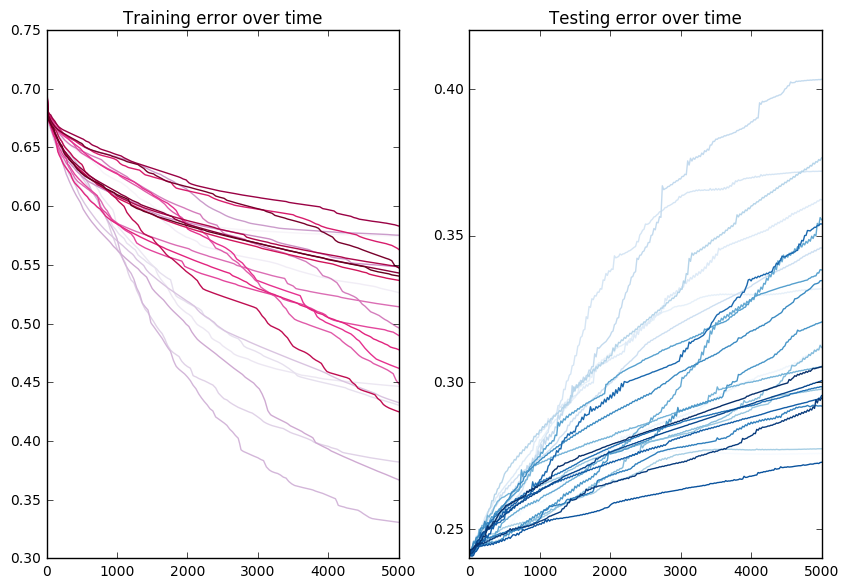

In [240]:
fig = plt.figure(figsize=(10,15))
cmap = plt.get_cmap('PuRd')
colors = [cmap(i) for i in np.linspace(0,1,len(nets))]
plt.subplot(221)
for color,(net,trace) in zip(colors,nets):
    ttrace = trace.T
    plt.plot(ttrace[0],ttrace[1],color=color)
plt.title('Training error over time')

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0,1,len(nets))]
plt.subplot(222)
for color,(net,trace) in zip(colors,nets):
    ttrace = trace.T
    plt.plot(ttrace[0],ttrace[2],color=color)
plt.title('Testing error over time')

Here is an interesting figure that I spent a lot of time creating and interpreting. To create this figure, I wrote a worker function, `traceWorker`,  for my `generateNetworks` function which trains a network on a set of data just like normal, except forward-passes a set of testing data (which really could be considered a validation set in this case) through the network once every specified number of iterations and records a trace of the training and testing error at each timestep. 

For this experiment, I trained 24 networks of varying sizes (generated using my `symmetrics` structure generator function) in parallel for 5000 iterations, recording the error traces at a 20 iteration timestep. In both plots, the size of the network is represented (loosely) by the saturation of the color of the curve representing its error over the iteration period. That is to say, the lighter the curve, the smaller the network.

The interesting thing that this figure illustrates is the misleading nature of overtraining. Even after 5000 iterations, the training error was still just beginning to converge even for the smallest network I trained ([16, 8, 16]). The smaller networks also tended to fit to the training data more quickly as you can see by the separation between the light and dark pink lines. However, for nearly every network structure, the error on the testing set seemed to be fairly steadily increasing, with the smaller networks increasing much more quickly.

If you had just looked at the training plot, you might assume that the networks all still needed a lot more iteration to converge to a minimum training error. However, looking at the testing plot, there's a small window very early in the training process which is not very clearly observable in this plot. Let's look at that area more closely:

In [252]:
results = generateNetworks(X, T, symmetrics(range(3,6,1),range(8,64,16),range(16,128,64),iterations=1), traceWorker, args=500)

In [253]:
nets = []
for i in results:
    nets.append(i)

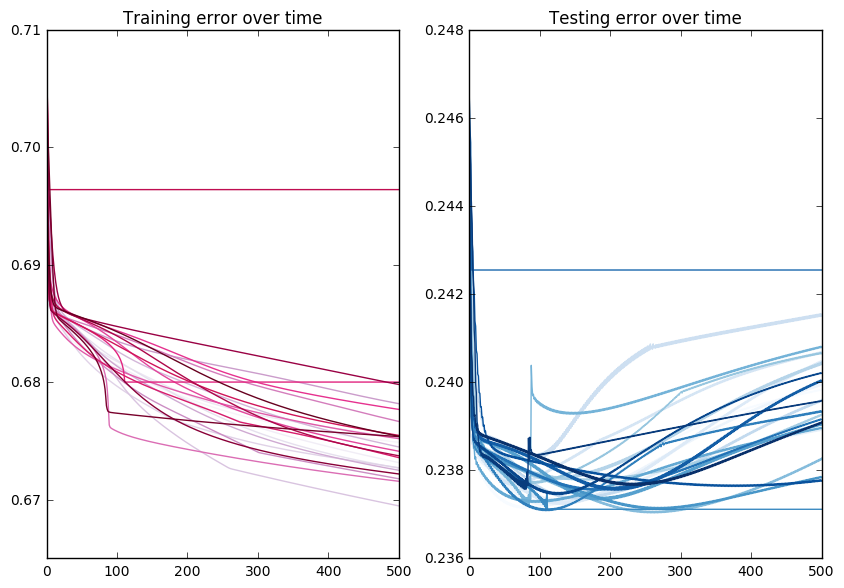

In [254]:
fig = plt.figure(figsize=(10,15))
cmap = plt.get_cmap('PuRd')
colors = [cmap(i) for i in np.linspace(0,1,len(nets))]
plt.subplot(221)
for color,(net,trace) in zip(colors,nets):
    ttrace = trace.T
    plt.plot(ttrace[0],ttrace[1],color=color)
plt.title('Training error over time')

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0,1,len(nets))]
plt.subplot(222)
for color,(net,trace) in zip(colors,nets):
    ttrace = trace.T
    plt.plot(ttrace[0],ttrace[2],color=color)
plt.title('Testing error over time')

I was really hoping to see a more defined local minimum in the testing error plot but on many of the networks you can observe that the optimal number of iterations is around 100-250, even though the training error is still fairly high. This is a good example of a dataset where just training to fit the data until the training error is close to 0 can still lead to missing the mark on new data by a large amount. 

In [259]:
print("Range of hotttness values: [{}, {}] \nStd deviation of hotttness values: {}".format(np.min(T),np.max(T),np.std(T)))

Range of hotttness values: [0.0, 1.0] 
Std deviation of hotttness values: 0.24719563483101661


I was very puzzled as to why, even at what appears to be an optimal number of iterations for nearly every network structure, the models were still producing >20% error (with RMSE values of ~0.237 where the target range is 1.0). However, it's important to remember that there can be a lot of natural variation in primary data. 

Interestingly, the standard deviation of the target attribute of this analysis (hotttness index) is actually 0.247. This means that on new data, the best models above are actually predicting the target variable with just about as much accuracy as there is natural variation from the mean in the data. However, this isn't a completely fair comparison as standard deviation is measure of variance from the mean of the data while the RMSE of a model doesn't compare samples to the mean, it compares a predicted value to a target value which may not actually be near enough to the mean for the standard deviation to be meaningful if the data does not follow a Gaussian distribution.

In [268]:
stats.normaltest(T)

NormaltestResult(statistic=array([ 1605.00905276]), pvalue=array([ 0.]))

Scipy's `normaltest` tells us that there is a 0 probability that normally distributed data would produce the chi-square value that our target variable produces. Maybe we need to look at the data more closely.

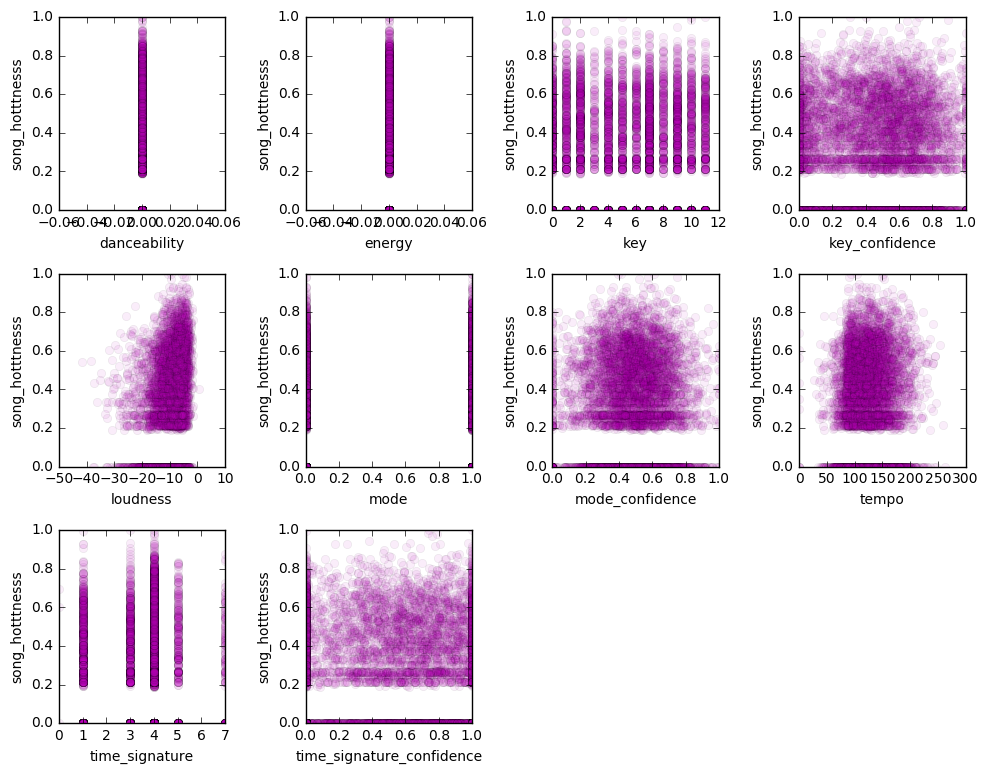

In [311]:
plt.figure(figsize=(10,10))
for c in range(X.shape[1]):
    plt.subplot(4,4, c+1)
    plt.plot(X[:,c], T, 'om', alpha=0.07)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])
plt.tight_layout()

Here is a good example of why you should always look closely at your data before you start training machine learning algorithms for hours. A lot of our samples seem to have a song hotttness value of 0. These are not actually interesting samples to consider, as they are clearly outliers from the data as shown by the clear separation between the 0 samples and the other samples over the above plots. Let's remove those samples and see if there are any improvements.

In [312]:
nz = np.nonzero(T)[0]
oldshape = (X.shape, T.shape)
X = X[nz]
T = T[nz]
newshape = (X.shape, T.shape)
print('Old shape: {}\nNew shape: {}'.format(oldshape,newshape))

Old shape: ((5647, 10), (5647, 1))
New shape: ((4213, 10), (4213, 1))


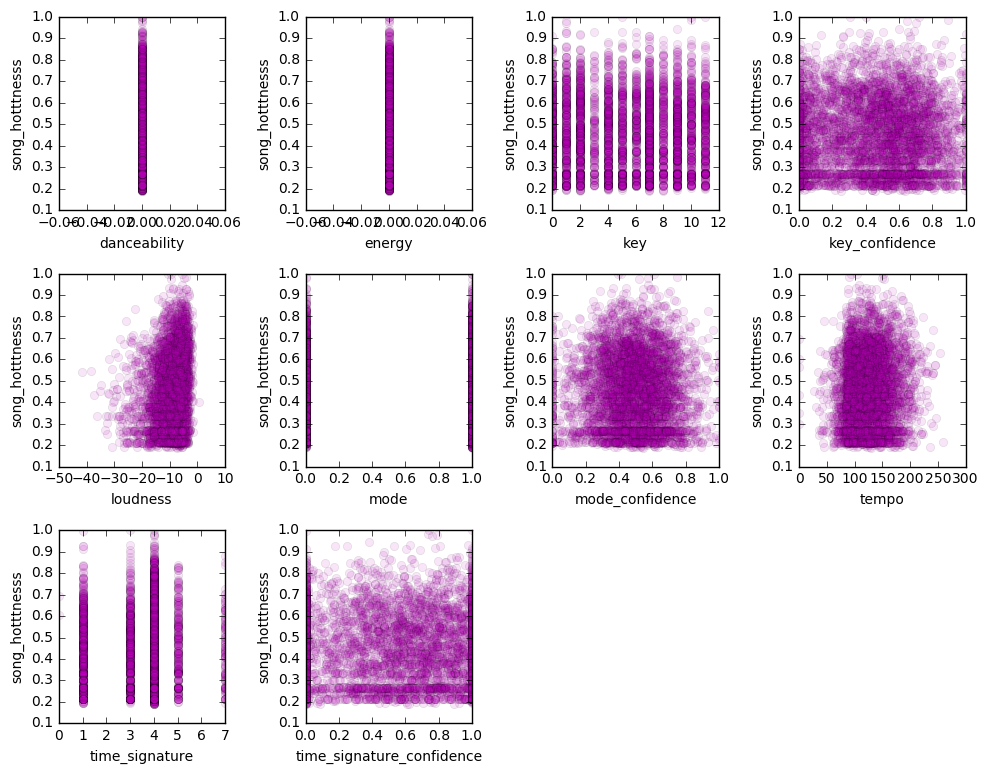

In [313]:
plt.figure(figsize=(10,10))
for c in range(X.shape[1]):
    plt.subplot(4,4, c+1)
    plt.plot(X[:,c], T, 'om', alpha=0.1)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])
plt.tight_layout()

In [300]:
results = generateNetworks(X, T, symmetrics(range(3,6,1),range(8,64,16),range(16,128,64),iterations=1), traceWorker, args=500)

In [301]:
nets = []
for i in results:
    nets.append(i)
print ('...done')

...done


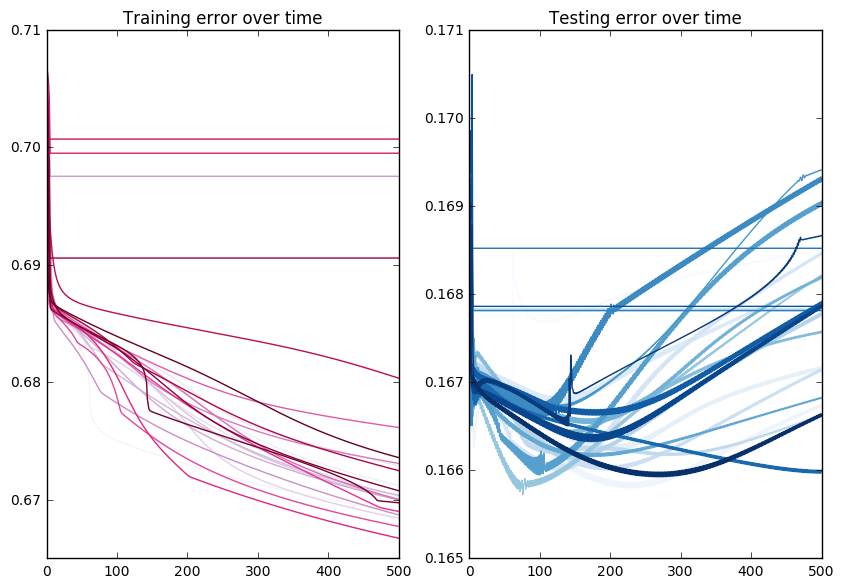

In [302]:
fig = plt.figure(figsize=(10,15))
cmap = plt.get_cmap('PuRd')
colors = [cmap(i) for i in np.linspace(0,1,len(nets))]
plt.subplot(221)
for color,(net,trace) in zip(colors,nets):
    ttrace = trace.T
    plt.plot(ttrace[0],ttrace[1],color=color)
plt.title('Training error over time')

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0,1,len(nets))]
plt.subplot(222)
for color,(net,trace) in zip(colors,nets):
    ttrace = trace.T
    plt.plot(ttrace[0],ttrace[2],color=color)
plt.title('Testing error over time')

After removing the obvious outlying samples, we've been able to reach an error of 0.166 with the largest network, down from around 0.237 before. Just like above, the optimal number of iterations seems to be around 100-300. 

In [304]:
np.std(T)

0.16822501519202068

Here's something I found very interesting. The standard deviation of the target variable went down to 0.168 after removing the 0 popularity outlier songs from the data. When I retrained all of the networks, the errors tended to have a local minimum around 0.166; just under the target standard deviation, just like before. This result sort of illustrates the point that if your networks can predict the target with similar error to the natural variation of the data, then the struggle for lower error lies less in the structure of the networks and more in your analysis of the data and its features.

One particular network structure seems to have lower test error than any other network with fewer iterations. However, the fluctuations in that curve could indicate that the network just randomly happened to approximate this testing data better. The deepest network structure, clearly visible in the blue graph above as the darkest blue curve, has very low testing error at a low number of iterations with a fairly stable decrease and increase which may indicate that it will perform more consistently on new data. I'll use that structure ([80, 68, 56, 68, 80]) as my final model.

In [325]:
np.argmin(np.array(nets[23][1]), axis=0)

array([  0, 500, 268], dtype=int64)

For that network, it looks like the minimum test error was obtained on iteration 268. The test error is specific to the randomly selected testing and training sets we selected, so the exact number isn't really important. I instead used 250 for convenience.

In [48]:
results = generateNetworks(X, T, symmetrics(range(3,6,1),range(32,64,8),range(64,128,32),iterations=5000))

In [49]:
nets = []
start = time.time()
for k in results:
    nets.append(k)
    print(k)
print('trained ',len(nets),' networks for ',(time.time()-start)/60.0,' minutes')

(NeuralNetwork(10, [64, 32, 64], 1)
   Network was trained for 5001 iterations. Final error is 0.018360756647731007., 0.44706525711020312)
(NeuralNetwork(10, [96, 32, 96], 1)
   Network was trained for 5001 iterations. Final error is 0.007993954570883895., 0.4229496267528941)
(NeuralNetwork(10, [64, 40, 64], 1)
   Network was trained for 5001 iterations. Final error is 6.0855766874901905e-05., 0.43091753683110523)
(NeuralNetwork(10, [96, 40, 96], 1)
   Network was trained for 5001 iterations. Final error is 1.3370779767143116e-06., 0.3919809454831939)
(NeuralNetwork(10, [64, 48, 64], 1)
   Network was trained for 5001 iterations. Final error is 3.0798873444815487e-07., 0.40703052188608096)
(NeuralNetwork(10, [96, 48, 96], 1)
   Network was trained for 5001 iterations. Final error is 0.00017014140353504938., 0.39243600740899837)
(NeuralNetwork(10, [64, 56, 64], 1)
   Network was trained for 5001 iterations. Final error is 2.8047199586591356e-08., 0.41019546608441398)
(NeuralNetwork(10, 

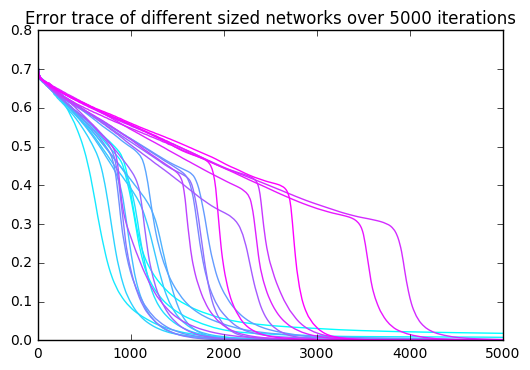

In [50]:
cmap = plt.get_cmap('cool')
colors = [cmap(i) for i in np.linspace(0,1,len(nets))]
for net,color in zip(nets,colors):
    plt.plot(net[0].getErrorTrace(),color=color)
plt.title('Error trace of different sized networks over 5000 iterations')

This plot illustrates the effect of network size on this particular dataset. Each curve on this plot is the training error trace of a single network from the set of networks trained above (all trained on the same data for 2000 iterations). The networks are color-coded representing their size, with the bluest curves representing the smallest networks in the set ([64, 32, 64]) and the pinkest curves representing the largest networks ([96, 76, 56, 76, 96]). After 5000 iterations, even that large network had been trained very tightly to the training data. This was a major problem with my initial parallel training system: in order to get every network trained sufficiently, the smaller networks ended up overtraining significantly.

## Results

In [337]:
partition = partitionData(X,T)

In [338]:
model = trainNN(partition[:2], [[80, 68, 56, 68, 80], 250])

In [339]:
error = evaluateNN(model, *partition[2:])

In [395]:
print('RMSE of final model: {}\nRange of target values: {}\nRatio of model RMSE to target range: {}'.format(error,np.ptp(T),error/np.ptp(T)))

RMSE of final model: 0.17668109660402342
Range of target values: 0.8121050207131133
Ratio of model RMSE to target range: 0.21755941916093427


In [341]:
actual = partition[3]
predicted = model.use(partition[2])

In [347]:
np.std(actual), np.std(predicted)

(0.16846156106235036, 0.07908870113070221)

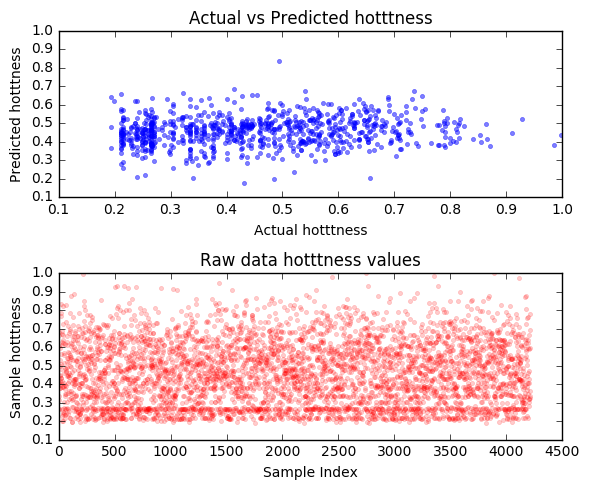

In [394]:
fig, ax = plt.subplots(2, sharey=True, figsize=(6,5))

ax[0].plot(actual, predicted,'.',alpha=0.5)
ax[0].set_xlabel('Actual hotttness')
ax[0].set_ylabel('Predicted hotttness')
ax[0].set_title('Actual vs Predicted hotttness')

ax[1].plot(T, '.r', alpha=0.2)
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Sample hotttness')
ax[1].set_title('Raw data hotttness values')
plt.tight_layout()

This result ended up being the best model I could come up with. One thing to note about this data and why it may have been so difficult to model accurately is the disproportionate number of samples with a hotttness index of around 0.25. This can be seen visibly as a horizontal red band in the raw data plot above. The effects of this can also be seen on the actual vs predicted plot above (blue) where there is a clear vertical blue band at around hotttness 0.26. Interestingly, there are a few other visible blue vertical bands in the above plot with less visibly observable corresponding bands in the raw data plot.

Obviously, a result with ~22% error is not ideal in a regression analysis. However, I think it's important to consider the standard deviation of the data in evaluating the model. Before and after removing the 0 hotttness outliers, the best models were able to converge very quickly to an RMSE very close to the standard deviation of the data. This shows that around the mean, the model is able to predict the target values with about as much accuracy as there is natural variation in the data.

## Conclusion

The main goal I had performing this analysis was to use nonlinear regression with neural networks to model the popularity index of a song based solely on its musical features. Using parallel network training and continual tracing of validation error, I was able to locate a network structure which provided relatively accurate results on new data in a small number of iterations. The framework I developed for training networks in parallel was very helpful in quickly generating a lot of models of different complexities, while the framework I developed to trace the error on a validation set was helpful in visualizing how the trained networks may perform on new data.

One of the biggest problems that I ran into over the course of the analysis was overtraining. Looking at the training error traces provided in the `NeuralNetwork` class, it appeared that the networks needed to be trained for a very long time, 4000 iterations or more, to have any chance of converging to a reasonable error. However, by tracing and plotting the error of the networks on a testing (or validation) set of data throughout the training process, I was able to figure out that the networks were overtraining significantly and that the best results on new data could be obtained by training them for far fewer iterations, around 300.

Of course, because the validation sets used were the same throughout the training process, it's possible that the structures I considered to be more accurate due to their low validation error actually just happened to fit the validation data that I used very accurately. However, because the error used to back-propogate the neural networks was from the training set, the error on the validation set did not have anything to do with the actual training process and thus did not bias the generation of each individual model.

The original goal I had in creating this model was to use the network I trained to be a reinforcement function for a reinforcement learning agent learning to play songs which would learn to play songs that had a high chance of being popular based solely on their musical features. After performing the analysis on this data, it's clear that this model would probably have had a very low chance of producing reliable enough results to allow for the reinforcement model to converge on any specific behaviour, especially considering the complexity of the state and action spaces of musical scoring. However, it's also important to note that while this analysis took into account around 0.4% of the entire million song dataset. Obviously, the exact methods and hardware I used in this analysis would not be feasible to analyze the entire 300GB million song dataset at once. However, this framework could be used to model separate parts of the dataset and form an ensemble of neural networks which may be able to more accurately and generally predict new data. 